In [2]:
#imports
import pandas as pd
from gpt4all import GPT4All
import gpt4all
#path = "C:\Users\Jakob\Downloads\gpt4all-falcon-q4_0.gguf"

from tqdm import tqdm
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *

import nltk
nltk.download('stopwords')
nltk.download('punkt')

import numpy as np

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

import os
import requests
from zipfile import ZipFile


import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\flori\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\flori\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\flori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Preprocessing of our data (creating smaller subset)

In [3]:
def split_file_by_lines(filename, lines_per_file,create_file):
    with open(filename, 'r', encoding='utf-8') as file: 
        count = 0
        current_file = open(create_file, 'w', encoding='utf-8') 
        
        numLine = 0
        count = 0
        for line in file:
            if(numLine > lines_per_file):
                break
            if (count % 1000) == 0:
                current_file.write(line)
                numLine += 1
            count += 1    


        current_file.close()

In [4]:
def split_file_by_lines_topic(filename, lines_per_file,create_file,topic):
    with open(filename, 'r', encoding='utf-8') as file: 
        count = 0
        current_file = open(create_file, 'w', encoding='utf-8') 
        
        numLine = 0
        count = 0
        for line in file:
            if(numLine > lines_per_file):
                break
            split_line = line.split(' ||| ')
            if topic in split_line[1]:
                current_file.write(line)
                numLine += 1
            count += 1    


        current_file.close()

get the complete titles for the queries in a dataframe

In [5]:
def txt_to_df_title(filename):
    fp = open(filename, 'r', encoding='utf-8')
    queries = []
    for entry in fp:
        query, _ = entry.split(' ||| ', 1)
        queries.append(query)
    df_queries = pd.DataFrame(queries, columns=['Query'])
    fp.close()
    return df_queries

In [6]:
def txt_to_df(filename):
    df = pd.read_csv(filename, delimiter=' \|\|\| ', engine='python', header=None, names=['Title', 'Text'])
    return df

Init the LLM

In [7]:
llm = GPT4All(model_name="gpt4all-falcon-q4_0.gguf",model_path="./model")

Generate a .txt file with the response of the llm as a document

In [8]:
def generateDocWithLLM(queries):
    fp = open("data/llmDocs.txt", 'a',encoding='utf-8')
    index = 0
    start = 0
    for title in queries['Title']:
        if start == 1:
            query = f'give me a short summary on {title}'
            input = query
            #print(input)
            with llm.chat_session():
                response = llm.generate(input, temp=0)
            #print(response)
            fp.write(str(title) + " ||| " + str(response) + "\n")
            # if(index == 3):
            #     break
        index += 1
        if(index % 50 == 0):
            print(index)
        if(index == 181):
            start = 1    
    fp.close()
    print("finished")  

In [9]:
#split_file_by_lines('data/stemmed.txt', 1000,'data/wikipediaSubset.txt')
#split_file_by_lines('data/raw.txt', 1000,'data/textForQueries.txt')
#df = txt_to_df('data/wikipediaSubset.txt')
#dfQ = txt_to_df_title('data/textForQueries.txt')


#split_file_by_lines_topic('data/raw.txt', 1000,'data/topic.txt',' sport ')
topic_dataframe = txt_to_df('data/topic.txt')

#display(df)
#display(dfQ)
# generateDocWithLLM(topic_dataframe)

# Preprocesses the data generated by the LLM as well as the original data

In [10]:
def file_iterator(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            split = line.split("|||")
            title = split[0]
            #join in the rare case this sequenze occurs more than once
            text = ''.join(map(str, split[1:]))
            yield (title, text)

def preprocess_Data(filename, isLLMData):
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    
    df = {}

    counter = 1
    for (title, text) in file_iterator(filename):
        
        if isLLMData:
            id = "L" + str(counter)
        else:
            id = "W" + str(counter)
            
        text = title + " " +text

        #Tokenize
        text = word_tokenize(text)

        #convert words to lowercase
        text = [t.lower() for t in text]

        #remove punctuation
        text = [t for t in text if t.isalnum() or t.isspace()]

        #remove stopwords
        text = [t for t in text if t not in stopwords_english]

        #stemm
        text = [stemmer.stem(t) for t in text]
        
        df[id] = text

        counter += 1

    return df


# Retriveing the first X documents using BM25. This is used for efficiently eliminating unreleveant documents. The resulting documaents are later reranked using more computaion intensive but also more acurate methods.

In [12]:
class BM25:
    def __init__(self, data):
        self.data = data
        self.k1 = 1.5
        self.b = 0.75
        self.inverted_index = self.calc_inverted_index()
        self.bm25 = self.calc_bm25_matrix()


    def calc_inverted_index(self) -> dict[str, list[str]]:

        inverted_index = {}
        
        for doc_id, words in self.data.items():
            for word in words:
                if word not in inverted_index.keys():
                    inverted_index[word] = []
                    inverted_index[word].append(doc_id)
                    
                else:
                    if doc_id not in inverted_index[word]:
                        inverted_index[word].append(doc_id)

        return inverted_index


    def calc_bm25_matrix(self):
            
        bm25 = {}     

        #construct vector for every word
        average_document_length = self.average_document_length()
        for doc_id, words in self.data.items():
            bm25[doc_id] = {}
            document_unique = np.unique(words)
            document = words
            documnet_id = doc_id
            for word in document_unique:
                idf = self.calculate_idf(len(self.inverted_index[word]))
                self.calc_bm25(word, bm25, idf, average_document_length, document, documnet_id)

        return bm25

    def calc_bm25(self, word, bm25, idf, average_document_length, document, documnet_id):
        
        term_frequency = document.count(word)
        
        numerator = idf * term_frequency * (self.k1 + 1)
        denominator = term_frequency + self.k1 * (1 - self.b + ((self.b * len(document)) / average_document_length))
        bm25[documnet_id][word] = numerator / denominator

    def average_document_length(self):
        element_counter = 0
        word_counter = 0
        for _, words in self.data.items():
            element_counter += 1
            word_counter += len(words)

        return word_counter / element_counter
    
    def calculate_idf(self, amount_documents_including_word):
        return np.log(len(self.data) / amount_documents_including_word)
    
    def preprocess_query(self, query: str):
        stemmer = PorterStemmer()
        stopwords_english = stopwords.words('english')

        #Tokenize
        query = word_tokenize(query)

        #convert words to lowercase
        query = [t.lower() for t in query]

        #remove punctuation
        query = [t for t in query if t.isalnum or t.isspace()]

        #remove stopwords
        query = [t for t in query if t not in stopwords_english]

        #stemm
        query = [stemmer.stem(t) for t in query]

        return query


    def retrieve_relevance(self, query: str, k: int) -> dict[str, float]:
        ### ADD YOUR CODE (BEGIN) ###

        query = self.preprocess_query(query)

        #filter out word not contained in any document for efficiency
        query = [word for word in query if word in self.inverted_index.keys()]

        bm25_current_query = {}

        for doc_id, words in self.data.items():
            bm25_current_query[doc_id] = []
            for word in query:
                if word in self.bm25[doc_id]:
                    bm25_current_query[doc_id].append(self.bm25[doc_id][word])
                else: 
                    bm25_current_query[doc_id].append(0)

        for key, value in bm25_current_query.items():
            bm25_current_query[key] = sum(value)

        sorted_bm25 = sorted(bm25_current_query.items(), key=lambda x:x[1], reverse=True)

        sorted_bm25 = sorted_bm25[:k]
        bm25_current_query = dict(sorted_bm25)

        return bm25_current_query


---
# Rerank using MonoBert

In [14]:
# download model

model_name = "castorini/monobert-large-msmarco"
model_path = "./model"

model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.save_pretrained(model_path)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.save_pretrained(model_path)

('./model\\tokenizer_config.json',
 './model\\special_tokens_map.json',
 './model\\vocab.txt',
 './model\\added_tokens.json',
 './model\\tokenizer.json')

In [15]:
model_path = "./model"

local_model = AutoModelForSequenceClassification.from_pretrained(model_path)
local_tokenizer = AutoTokenizer.from_pretrained(model_path)

In [16]:
def get_relevance_bert(query, documents):
    relevances = []
    for document in documents:
        
        inputs = tokenizer(query, document[1], return_tensors="pt", padding=True, truncation=True)

        # predictions    
        with torch.no_grad():
            outputs = model(**inputs)

        logits = outputs.logits

        # e.g.:
        # outputs: SequenceClassifierOutput(loss=None, logits=tensor([[-1.8822,  2.8848]]), hidden_states=None, attentions=None)
        # logits: tensor([[-1.8822,  2.8848]])

        # re-scale to [0,1] and so that sum == 1
        relevance = torch.nn.functional.softmax(logits, dim=1)
        relevances.append([document[0], relevance[0].tolist()[1], document[1]])

    return relevances

In [17]:
def order_relevance(relevances):
    relevances = sorted(relevances, reverse=True, key=lambda x: x[1])
    return relevances

# Full retrival pipeline using BM25 and BERT

In [19]:
class Pipeline:
    def __init__(self, amount_bm25_fetched_documents, amount_of_queries):
        data=self.getData()
        self.bm25 = BM25(data)
        self.documents = self.getCompleteFiles()
        self.amount_bm25_fetched_documents = amount_bm25_fetched_documents
        self.queries = self.get_queries_from_doc()
        self.amount_of_queries = amount_of_queries

    def getData(self):
        data = preprocess_Data('data/llmDocs.txt', True)
        data2 = preprocess_Data('data/topic.txt', False)
        data |= data2
        return data
    
    def getCompleteFiles(self):
        documents = {}

        #read LLM generated Documents
        counter = 1
        with open('data/llmDocs.txt', 'r', encoding='utf-8') as file:
            for line in file:
                split = line.split("|||")
                #join in the rare case this sequenze occurs more than once
                text = ''.join(map(str, split[1:]))
                documents["L"+str(counter)] = text
                counter+=1

        #read original wikipedia documents
        counter = 1
        with open('data/topic.txt', 'r', encoding='utf-8') as file:
            for line in file:
                split = line.split("|||")
                #join in the rare case this sequenze occurs more than once
                text = ''.join(map(str, split[1:]))
                documents["W"+str(counter)] = text
                counter+=1
        
        return documents
    
    def retrieve_relevant_documents_with_BERT(self, query, documents):
        relevances = get_relevance_bert(query, documents)
        relevances = order_relevance(relevances)   
        return relevances 
    
    def retrieve_relevant_documents(self, query):

        #retrieve amount_bm25_fetched_documents documents using fast bm25
        bm25_docs = self.bm25.retrieve_relevance(query, self.amount_bm25_fetched_documents)

        #fetch the non preprocessed documents retrieved by bm25
        retrieved_documents = []
        for doc_id in bm25_docs:
            retrieved_documents.append([doc_id, self.documents[doc_id]])

        #rerank these documents using BERT
        ranked_document_list = self.retrieve_relevant_documents_with_BERT(query, retrieved_documents)

        return ranked_document_list

    def get_queries_from_doc(self):
        queries_list = []
        with open('data/topic.txt', 'r', encoding='utf-8') as file:
            for line in file:
                split = line.split("|||")
                queries_list.append(split[0])
        return queries_list
    
    def run_queries(self):
        ret = []
        for query in self.queries[:self.amount_of_queries]:
            ret.append((query, self.retrieve_relevant_documents(query)))

        return ret


In [27]:
pip = Pipeline(5, 100)

# ranked_document_list = pip.retrieve_relevant_documents("formula one is no fun")
# for doc in ranked_document_list:
#    print(doc)

results = pip.run_queries()

# Visualize Results using plots

In [82]:

def calculate_percent_relevant_answers(query_results, amount_docs_evalueted_per_query, use_only_relevant_results):

	if amount_docs_evalueted_per_query <= 0 or amount_docs_evalueted_per_query > len(query_results[0][1]):
		print("INVALID PARAM")
		return
        
	percent_llmgenerated_in_relevant_results = []
	percent_wikigenerated_in_relevant_results = []
	for query_result in query_results:
		curr_results = query_result[1]
		llm_generated_count = 0
		wiki_generated_count = 0
		counter = 0
		for doc in curr_results:

			#check first amount_docs_evalueted_per_query docs regardless if there deemed relevant
			if counter >= amount_docs_evalueted_per_query and not use_only_relevant_results:
				break

			#result not relvant according to bert
			if use_only_relevant_results and doc[1] < 0.5:
				break
			if 'L' in doc[0]:
				llm_generated_count+=1

			if 'W' in doc[0]:
				wiki_generated_count+=1

			counter+=1

		# print(str(wiki_generated_count) + " " + str(llm_generated_count) +" " +str(counter))
		if not use_only_relevant_results:
			percent_llmgenerated_in_relevant_results.append(llm_generated_count / amount_docs_evalueted_per_query)
			percent_wikigenerated_in_relevant_results.append(wiki_generated_count / amount_docs_evalueted_per_query)
		else:
			percent_llmgenerated_in_relevant_results.append(llm_generated_count / counter if counter > 0 else 0)
			percent_wikigenerated_in_relevant_results.append(wiki_generated_count / counter if counter > 0 else 0)

	print("Average Percent across LLM generated results: " +str(sum(percent_llmgenerated_in_relevant_results) / len(percent_llmgenerated_in_relevant_results)))
	print("Average Percent across Wiki generated results: " +str(sum(percent_wikigenerated_in_relevant_results) / len(percent_wikigenerated_in_relevant_results)))
	return percent_llmgenerated_in_relevant_results, percent_wikigenerated_in_relevant_results


def calculate_avg_positioning_of_llm_and_wiki_answers(query_results, amount_docs_evalueted_per_query, use_only_relevant_results):

	if amount_docs_evalueted_per_query <= 0 or amount_docs_evalueted_per_query > len(query_results[0][1]):
		print("INVALID PARAM")
		return
        
	llm_avgs = []
	wiki_avgs = []
	
	for query_result in query_results:

		curr_results = query_result[1]
		llm_avg = 0
		llm_counter = 0
		wiki_avg = 0
		wiki_counter = 0
		counter = 1
		for doc in curr_results:
			if counter > amount_docs_evalueted_per_query and not use_only_relevant_results:
				break
			if doc[1] < 0.5 and use_only_relevant_results:
				break
			if 'L' in doc[0]:
				llm_avg += counter
				llm_counter += 1
			else:
				wiki_avg += counter
				wiki_counter += 1

			counter+=1

		llm_avgs.append(llm_avg/llm_counter if llm_counter>0 else 0)
		wiki_avgs.append(wiki_avg/wiki_counter if wiki_counter >0 else 0)

	print("Average of average positions across LLM generated results: " +str(sum(llm_avgs) / len(llm_avgs)))
	print("Average of average positions across Wiki generated results: " +str(sum(wiki_avgs) / len(wiki_avgs)))

	return llm_avgs, wiki_avgs

def calculate_position_of_first_LLM_and_Wiki_answer(query_results, amount_docs_evalueted_per_query, use_only_relevant_results):
	if amount_docs_evalueted_per_query <= 0 or amount_docs_evalueted_per_query > len(query_results[0][1]):
		print("INVALID PARAM")
		return
        
	llm_positions = []
	wiki_positions = []
	
	for query_result in query_results:

		curr_results = query_result[1]
		llm_index_found = False
		wiki_index_found = False
		counter = 1
		for doc in curr_results:
			if counter > amount_docs_evalueted_per_query and not use_only_relevant_results:
				break
			if use_only_relevant_results and doc[1] < 0.5:
				break
			if 'L' in doc[0] and not llm_index_found:
				llm_index_found = True
				llm_positions.append(counter)

			elif 'W' in doc[0] and not wiki_index_found:
				wiki_positions.append(counter)
				wiki_index_found = True

			counter+=1
		if not wiki_index_found:
			wiki_positions.append(0)
		if not llm_index_found:
			llm_positions.append(0)

	print("Average first position across LLM generated results: " +str(sum(llm_positions) / len(llm_positions)))
	print("Average first position across Wiki generated results: " +str(sum(wiki_positions) / len(wiki_positions)))
	return llm_positions, wiki_positions

def display_percent_relevant_answers(query_results, amount_docs_evalueted_per_query, use_only_relevant_results):
	llm_percent, wiki_percent = calculate_percent_relevant_answers(query_results, amount_docs_evalueted_per_query, use_only_relevant_results)
	x = np.arange(len(llm_percent)) 
	plt.bar(x-0.2, llm_percent, 0.4, label='LLM docs relvency') 
	plt.bar(x+0.2, wiki_percent, 0.4, label='Wiki docs relevancy')
	plt.title('Relevancy of docs [%]: '+ ('Top X documents' if not use_only_relevant_results else 'All relevant documents'))
	plt.xlabel('Query')
	plt.ylabel('Relevancy [%]')
	plt.legend()
	plt.figure(figsize=(14, 6))

def display_avg_positioning_of_llm_and_wiki_answers(query_results, amount_docs_evalueted_per_query, use_only_relevant_results):
	llm_avgs, wiki_avgs = calculate_avg_positioning_of_llm_and_wiki_answers(query_results, amount_docs_evalueted_per_query, use_only_relevant_results)
	plt.plot(range(1, len(llm_avgs) + 1), llm_avgs, label='AVG LLM doc position')
	plt.plot(range(1, len(wiki_avgs) + 1), wiki_avgs, label='AVG Wiki doc position')
	plt.title('AVG position of answers: ' + ('Top X documents' if not use_only_relevant_results else 'All relevant documents'))
	plt.xlabel('Query')
	plt.ylabel('Avg Position')
	plt.legend()
	plt.figure(figsize=(14, 6))
	# plt.show()

def display_position_of_first_LLM_and_Wiki_answer(query_results, amount_docs_evalueted_per_query, use_only_relevant_results):
	llm_positions, wiki_positions = calculate_position_of_first_LLM_and_Wiki_answer(query_results, amount_docs_evalueted_per_query, use_only_relevant_results)
	plt.scatter(range(1, len(llm_positions) + 1), llm_positions, label='First LLM doc position')
	plt.scatter(range(1, len(wiki_positions) + 1), wiki_positions, label='First Wiki doc position')
	plt.title('First position of answers: '+ ('Top X documents' if not use_only_relevant_results else 'All relevant documents'))
	plt.xlabel('Query')
	plt.ylabel('First Position')
	plt.legend()
	plt.figure(figsize=(14, 6))
	# plt.show()

Average Percent across LLM generated results: 0.45199999999999974
Average Percent across Wiki generated results: 0.5480000000000003
Average Percent across LLM generated results: 0.44466666666666654
Average Percent across Wiki generated results: 0.5353333333333334
Average of average positions across LLM generated results: 2.7391666666666667
Average of average positions across Wiki generated results: 2.87
Average of average positions across LLM generated results: 1.685
Average of average positions across Wiki generated results: 1.8816666666666666
Average first position across LLM generated results: 1.56
Average first position across Wiki generated results: 1.55
Average first position across LLM generated results: 1.47
Average first position across Wiki generated results: 1.48


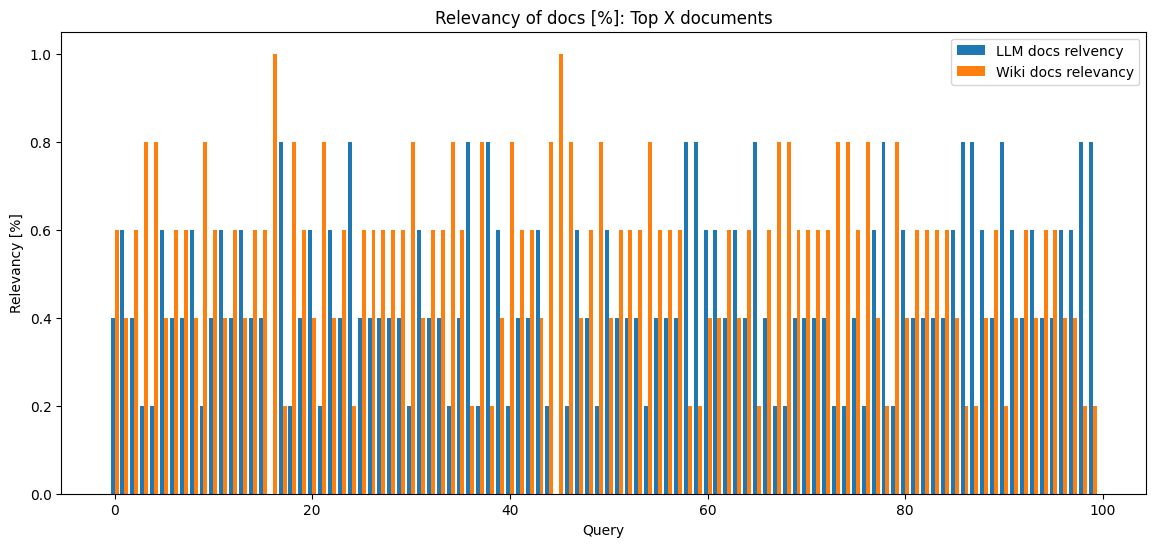

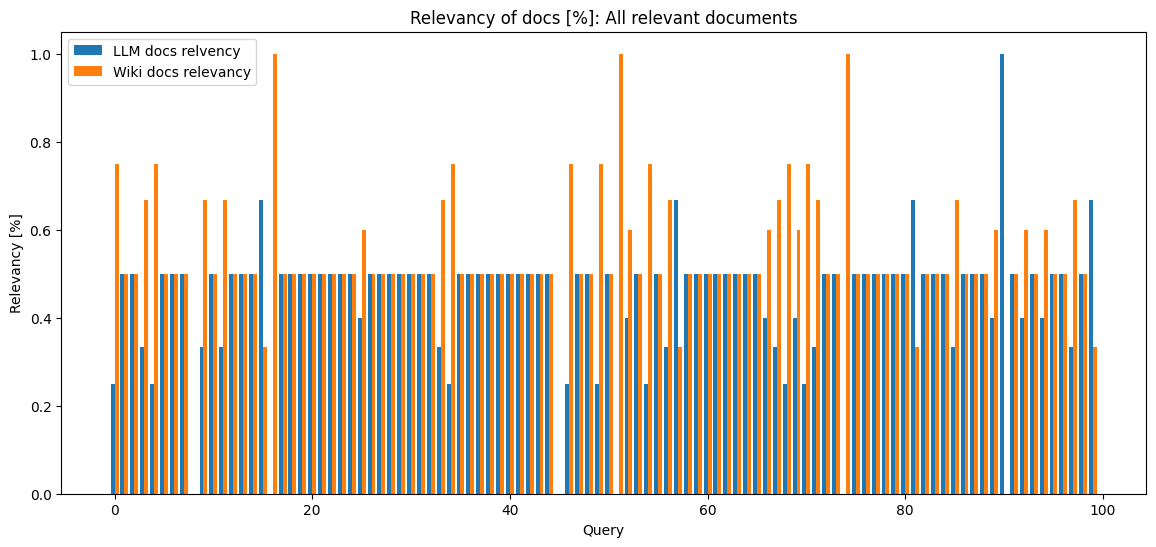

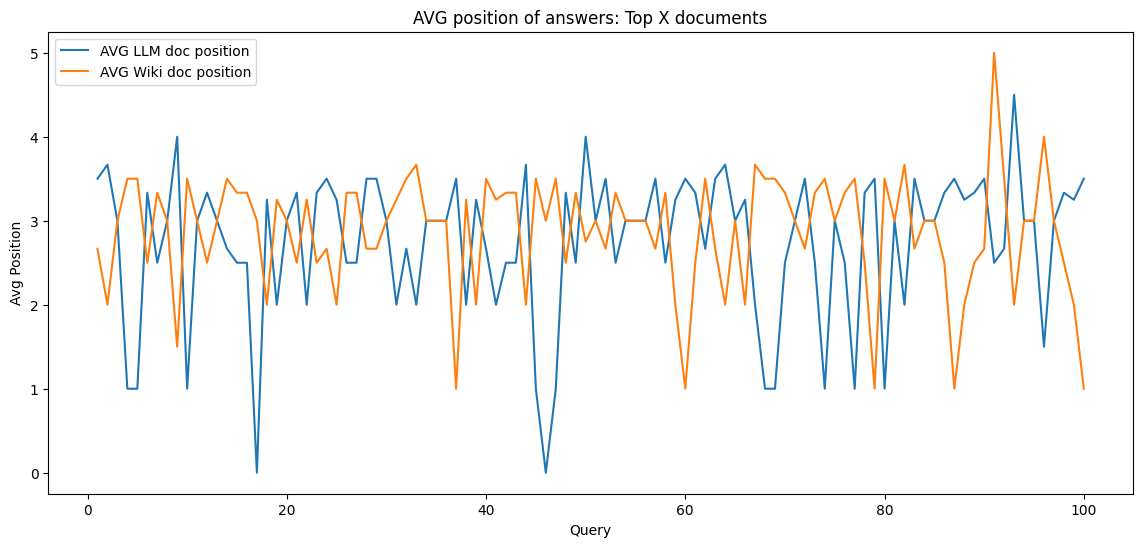

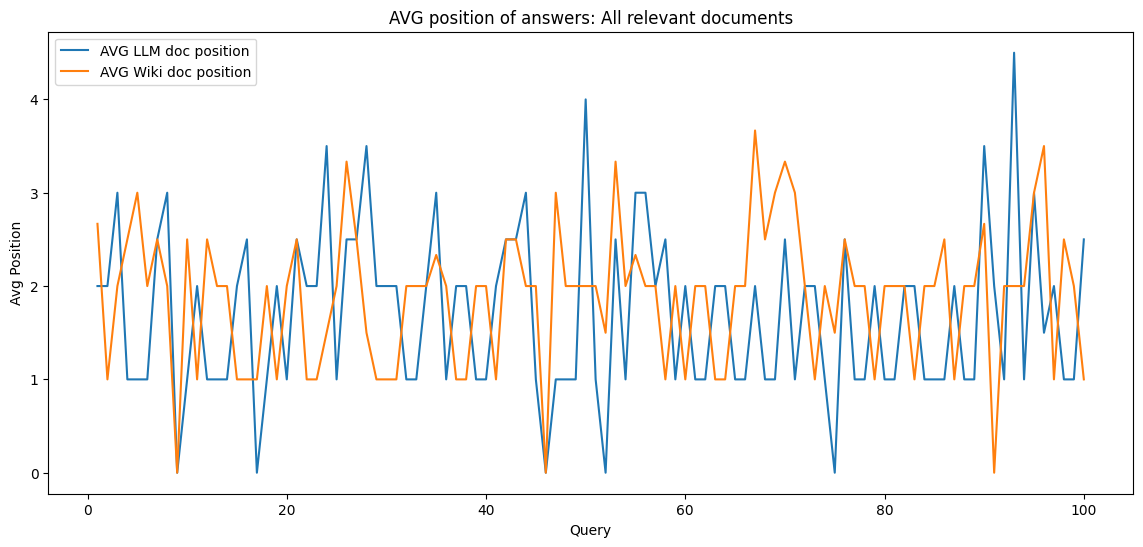

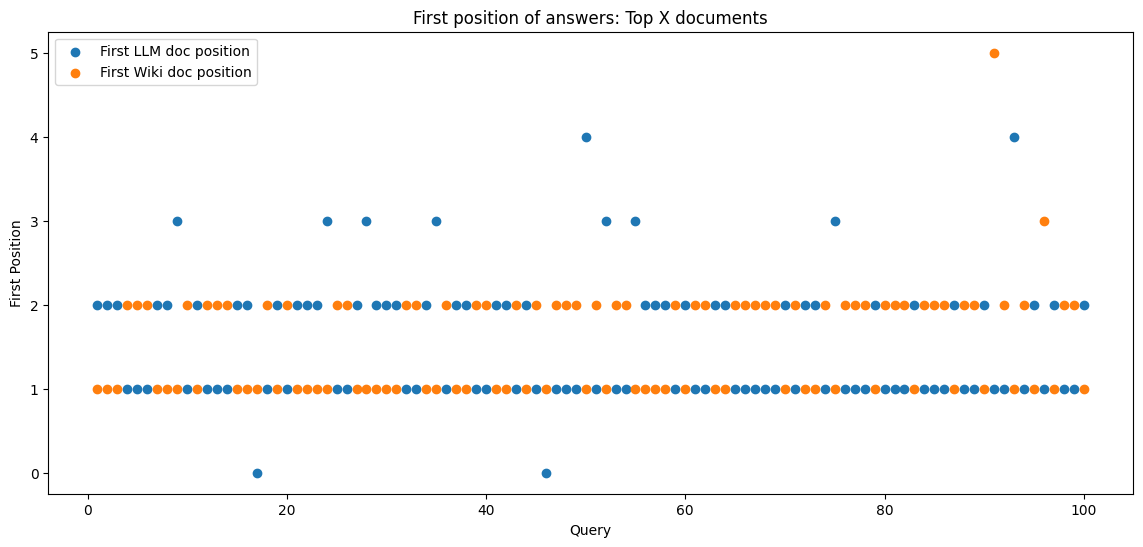

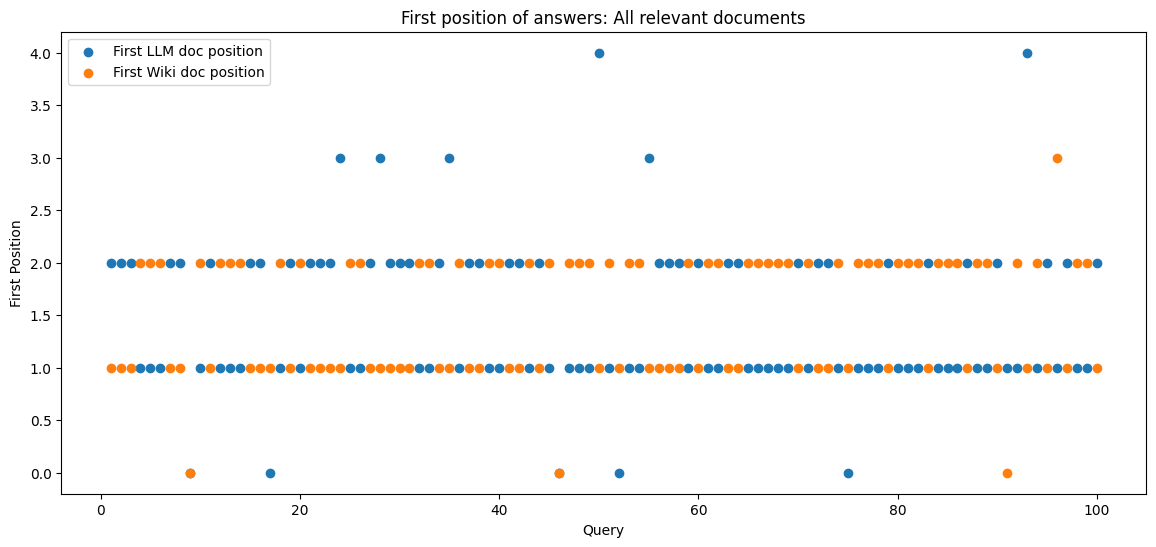

<Figure size 1400x600 with 0 Axes>

In [83]:
plt.figure(figsize=(14, 6))
display_percent_relevant_answers(results, 5, False)
display_percent_relevant_answers(results, 5, True)
display_avg_positioning_of_llm_and_wiki_answers(results, 5, False)
display_avg_positioning_of_llm_and_wiki_answers(results, 5, True)
display_position_of_first_LLM_and_Wiki_answer(results, 5, False)
display_position_of_first_LLM_and_Wiki_answer(results, 5, True)
